In [ ]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.signal as sig
import pickle
import os.path

import sys
sys.path.append('..')
from systemprbm import UnitCell, System
import prbm_helper_functions as phf

import scipy.interpolate as interp
from ECA_plotting import *
from ElementaryCA import *
from matplotlib.animation import FuncAnimation

params = phf.define_params()
rule_dict = separable_rules()

# params["tog_offset"]=1.4e-3
#load results
filename = 'data/PRBM_2_110_10.pkl'
with open(filename, 'rb') as f:
    results, y, t = pickle.load(f)
        


In [5]:
config = [0]
system = System(config,params)
d6range = np.linspace(28.7e-3,60e-3,20)
slopes = []
for d6 in d6range:
    slopes.append(system.get_threshold_stiffnesses(d6max=d6))
slopes = np.array(slopes)
slopes = slopes[:,:,2]
stiffness_ratio = slopes[:,1]/slopes[:,0]
slope1_spline = interp.UnivariateSpline(d6range, -slopes[:,0], s=0)
slope2_spline = interp.UnivariateSpline(d6range, -slopes[:,1], s=0)
stiffness_ratio_spline_inverse = interp.UnivariateSpline(stiffness_ratio[::-1], d6range[::-1], s=0)

In [6]:
n = 10
rulenum = 110
rule = rule_dict[rulenum]
d6 = stiffness_ratio_spline_inverse(rule[1][1]/rule[1][0])
k_critical = slope1_spline(d6)
k_critical2 = slope2_spline(d6)
stiffnesses = rule[0]*k_critical/rule[1][0]
params['K1'],params['K2'],params['K3'] = stiffnesses
config = [0]*n
config[-1] = 1
system = System(config,params)

# results, y, t = system.simulate_actuation(n_cycles=n)

In [2]:
#pickle and save results
filename = 'data/PRBM_2_110_10.pkl'
with open(filename, 'wb') as f:
    pickle.dump([results, y, t], f)

#load results
with open(filename, 'rb') as f:
    results, y, t = pickle.load(f)
        


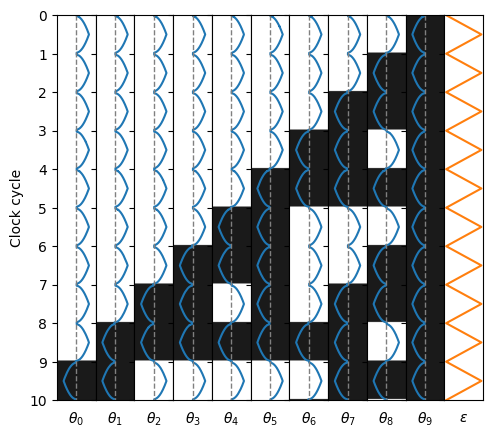

In [179]:



fig, axes = plt.subplots(1,len(config)+1,figsize=((n+1)/2,n/2), sharey=True,dpi=100)
plt.subplots_adjust(wspace=0)
for i,ax in enumerate(axes[:-1]):
    image_data = np.ones((results.shape[0], 1))

    # color entries of the image according to the value of the corresponding pixel in the results array, 0 if the value is negative and 1 if it is positive
    image_data[results[:,2*i+1]<0] = 0

    ax.invert_yaxis()
    ax.imshow(image_data, aspect='auto', extent=[xlim:= -0.8, -xlim, t[-1], t[0]], cmap='gray',alpha=0.9)
    ax.plot(results[:,2*i+1],t)
    ax.set_xlim([xlim,-xlim])
    ax.vlines(0,color='grey',ymin=t[0],ymax=t[-1],linestyle='dashed',lw=1)
    ax.set_xlabel(r'$\theta_{}$'.format(i))
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n+1))
    # ax.grid()

axes[0].set_ylabel('Clock cycle')
d6max = 33e-3
umax = 2*(system.params['L4']-np.sqrt(system.params['L4']**2-d6max**2))
u_range = (sig.sawtooth(2*np.pi*t, width=0.5)+1)/2*(umax-system.u_init)+system.u_init

ax = axes[-1]
ax.plot(u_range,t,color= 'tab:orange')
ax.set_xticks([])
ax.set_yticks(np.arange(0,n+1))
ax.set_xlabel(r'$\epsilon$')

#SAVE PDF IN IMAGES FOLDER
plt.savefig('C:/Users/eoinl/ThesisCode/Thesis/LaTeX/images/simulation.pdf',bbox_inches='tight')



Text(0, 0.5, 'Clock cycle')

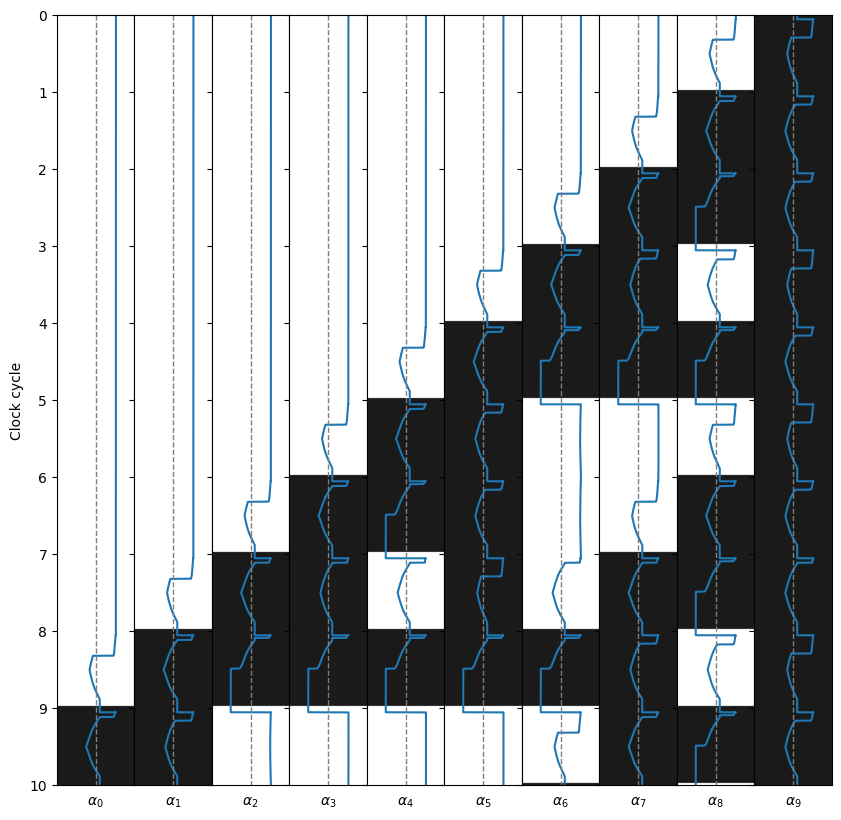

In [59]:
fig, axes = plt.subplots(1,len(config),figsize=(n,n), sharey=True)
plt.subplots_adjust(wspace=0)
for i,ax in enumerate(axes):
    image_data = np.ones((results.shape[0], 1))

    # color entries of the image according to the value of the corresponding pixel in the results array, 0 if the value is negative and 1 if it is positive
    image_data[results[:,2*i+1]<0] = 0

    ax.invert_yaxis()
    ax.imshow(image_data, aspect='auto', extent=[xlim:= -0.8, -xlim, t[-1], t[0]], cmap='gray',alpha=0.9)
    ax.plot(results[:,2*i],t)
    ax.set_xlim([xlim,-xlim])
    ax.vlines(0,color='grey',ymin=t[0],ymax=t[-1],linestyle='dashed',lw=1)
    ax.set_xlabel(r'$\alpha_{}$'.format(i))
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n+1))
    # ax.grid()

axes[0].set_ylabel('Clock cycle')

Text(0, 0.5, 'Clock cycle')

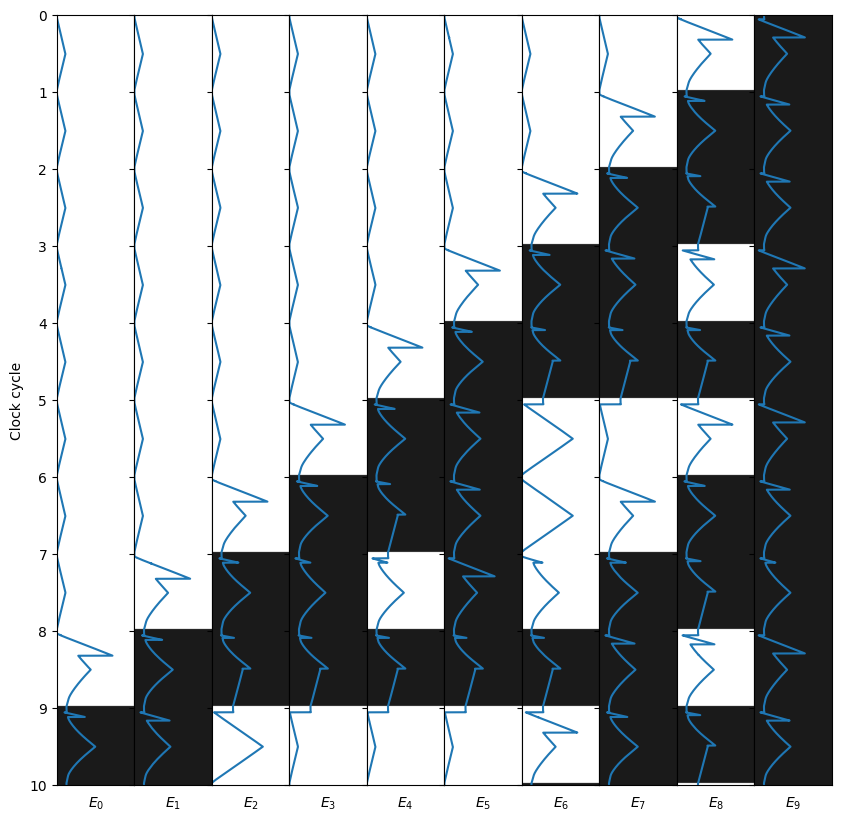

In [73]:
fig, axes = plt.subplots(1,len(config),figsize=(n,n), sharey=True)
plt.subplots_adjust(wspace=0)
for i,ax in enumerate(axes):
    image_data = np.ones((results.shape[0], 1))

    # color entries of the image according to the value of the corresponding pixel in the results array, 0 if the value is negative and 1 if it is positive
    image_data[results[:,2*i+1]<0] = 0

    ax.invert_yaxis()
    ax.imshow(image_data, aspect='auto', extent=[xlim_l:= 0, xlim_u:=0.1, t[-1], t[0]], cmap='gray',alpha=0.9)
    ax.plot(y['E'][i],t)
    ax.set_xlim([xlim_l,xlim_u])
    ax.set_xlabel(r'$E_{}$'.format(i))
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n+1))
    # ax.grid()

axes[0].set_ylabel('Clock cycle')

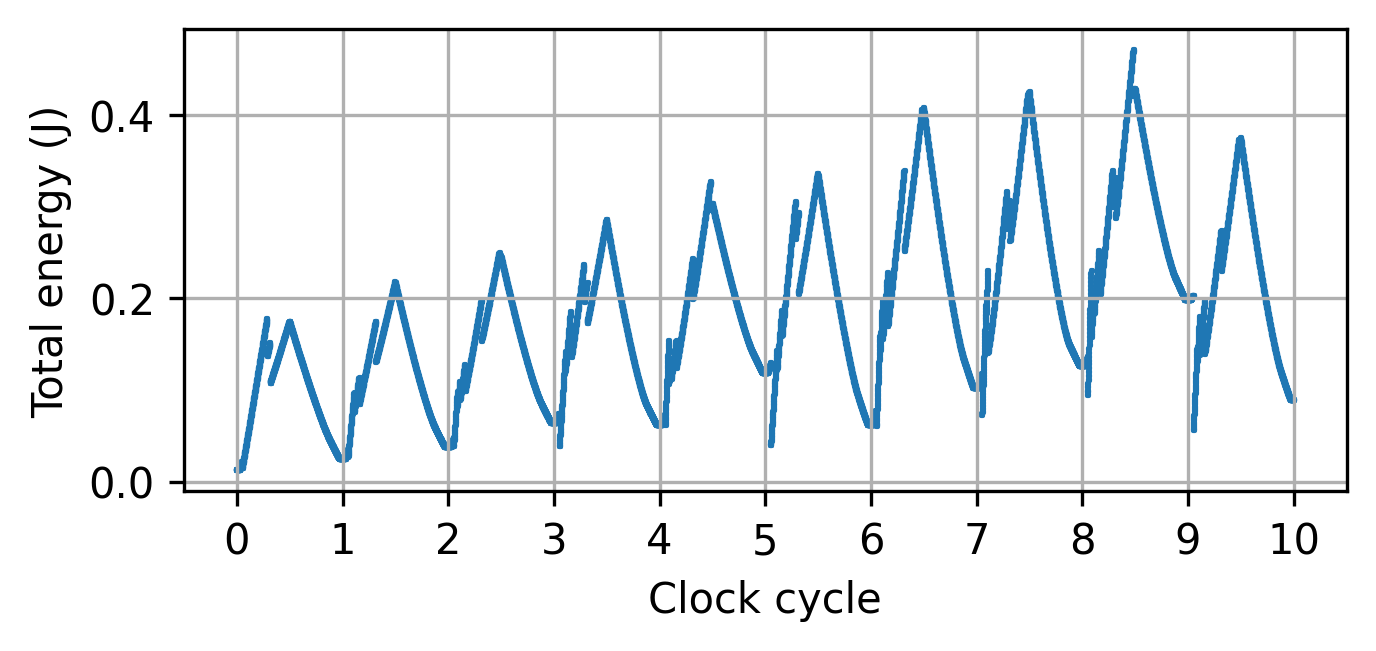

In [ ]:
fig = plt.figure(figsize=(5,2),dpi=150)
ax = plt.axes()
ax.scatter(t,y['E'].sum(axis=0),marker=',',color='tab:blue',s=0.1)
ax.set_xlabel('Clock cycle')
ax.set_ylabel('Total energy (J)')
ax.set_xticks(np.arange(0,n+1))
ax.grid()





In [46]:
#plot derivative of energy, filtering for discontinuities
E_tot = y['E'].sum(axis=0)

#save energy data to file
filename = 'data/PRBM_2_110_10_energy.pkl'
with open(filename, 'wb') as f:
    pickle.dump([t,E_tot,u_range], f)
    




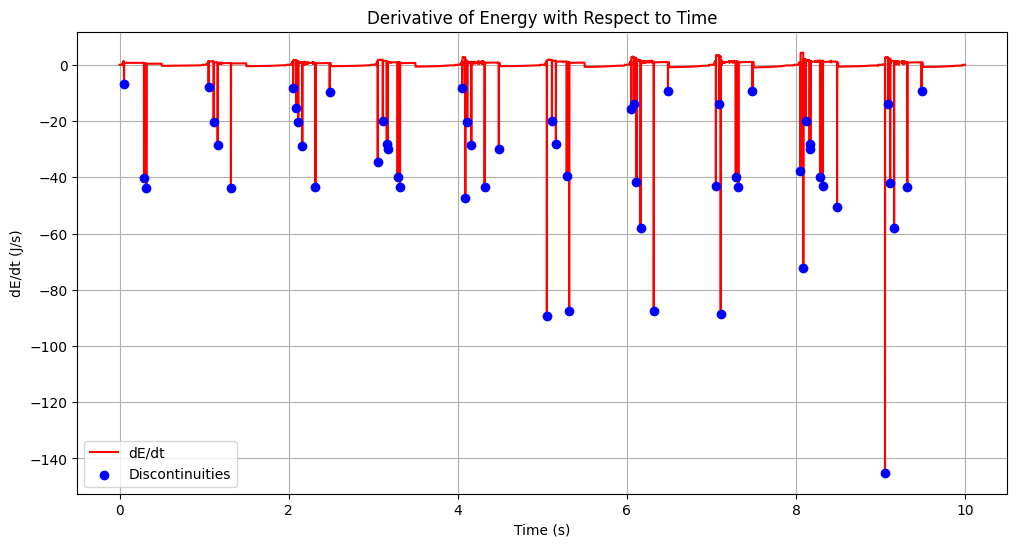

array([  53,  289,  317, 1053, 1113, 1160, 1317, 2053, 2090, 2113, 2161,
       2317, 2485, 3053, 3113, 3160, 3170, 3288, 3317, 4053, 4089, 4112,
       4160, 4317, 4485, 5053, 5113, 5160, 5288, 5317, 6052, 6089, 6113,
       6161, 6317, 6485, 7052, 7090, 7109, 7287, 7318, 7485, 8052, 8086,
       8112, 8160, 8170, 8288, 8317, 8485, 9052, 9089, 9113, 9160, 9316,
       9484], dtype=int64)

In [50]:
time = t
energy = E_tot


# Calculate the derivative of energy with respect to time to find discontinuities
dE_dt = np.diff(energy) / np.diff(time)

# Define a threshold for identifying discontinuities
threshold = np.std(dE_dt)*1.5 

# Find the indices where the derivative exceeds the threshold
discontinuity_indices = np.where(np.abs(dE_dt) > threshold)[0]

# Plot the derivative of energy and mark the discontinuities
plt.figure(figsize=(12, 6))
plt.plot(time[:-1], dE_dt, label='dE/dt', color='r')
plt.scatter(time[discontinuity_indices], dE_dt[discontinuity_indices], color='b', zorder=5, label='Discontinuities')
plt.title('Derivative of Energy with Respect to Time')
plt.xlabel('Time (s)')
plt.ylabel('dE/dt (J/s)')
plt.grid(True)
plt.legend()
plt.show()

# Show the identified discontinuity indices
discontinuity_indices

In [80]:
# Add the start and end indices to the list of discontinuities
input_displacement = u_range
segment_indices = np.concatenate(([0], discontinuity_indices + 1, [len(time) - 1]))

# Initialize lists to store segmented data
segmented_energy = []
segmented_displacement = []
segmented_time = []

# Segment the data into continuous portions based on the identified discontinuities
for start_idx, end_idx in zip(segment_indices[:-1], segment_indices[1:]):
    segmented_energy.append(energy[start_idx:end_idx])
    segmented_displacement.append(input_displacement[start_idx:end_idx])
    segmented_time.append(time[start_idx:end_idx])

# Number of segments created
num_segments = len(segmented_energy)

num_segments


57

Text(0, 0.5, 'Total energy (J)')

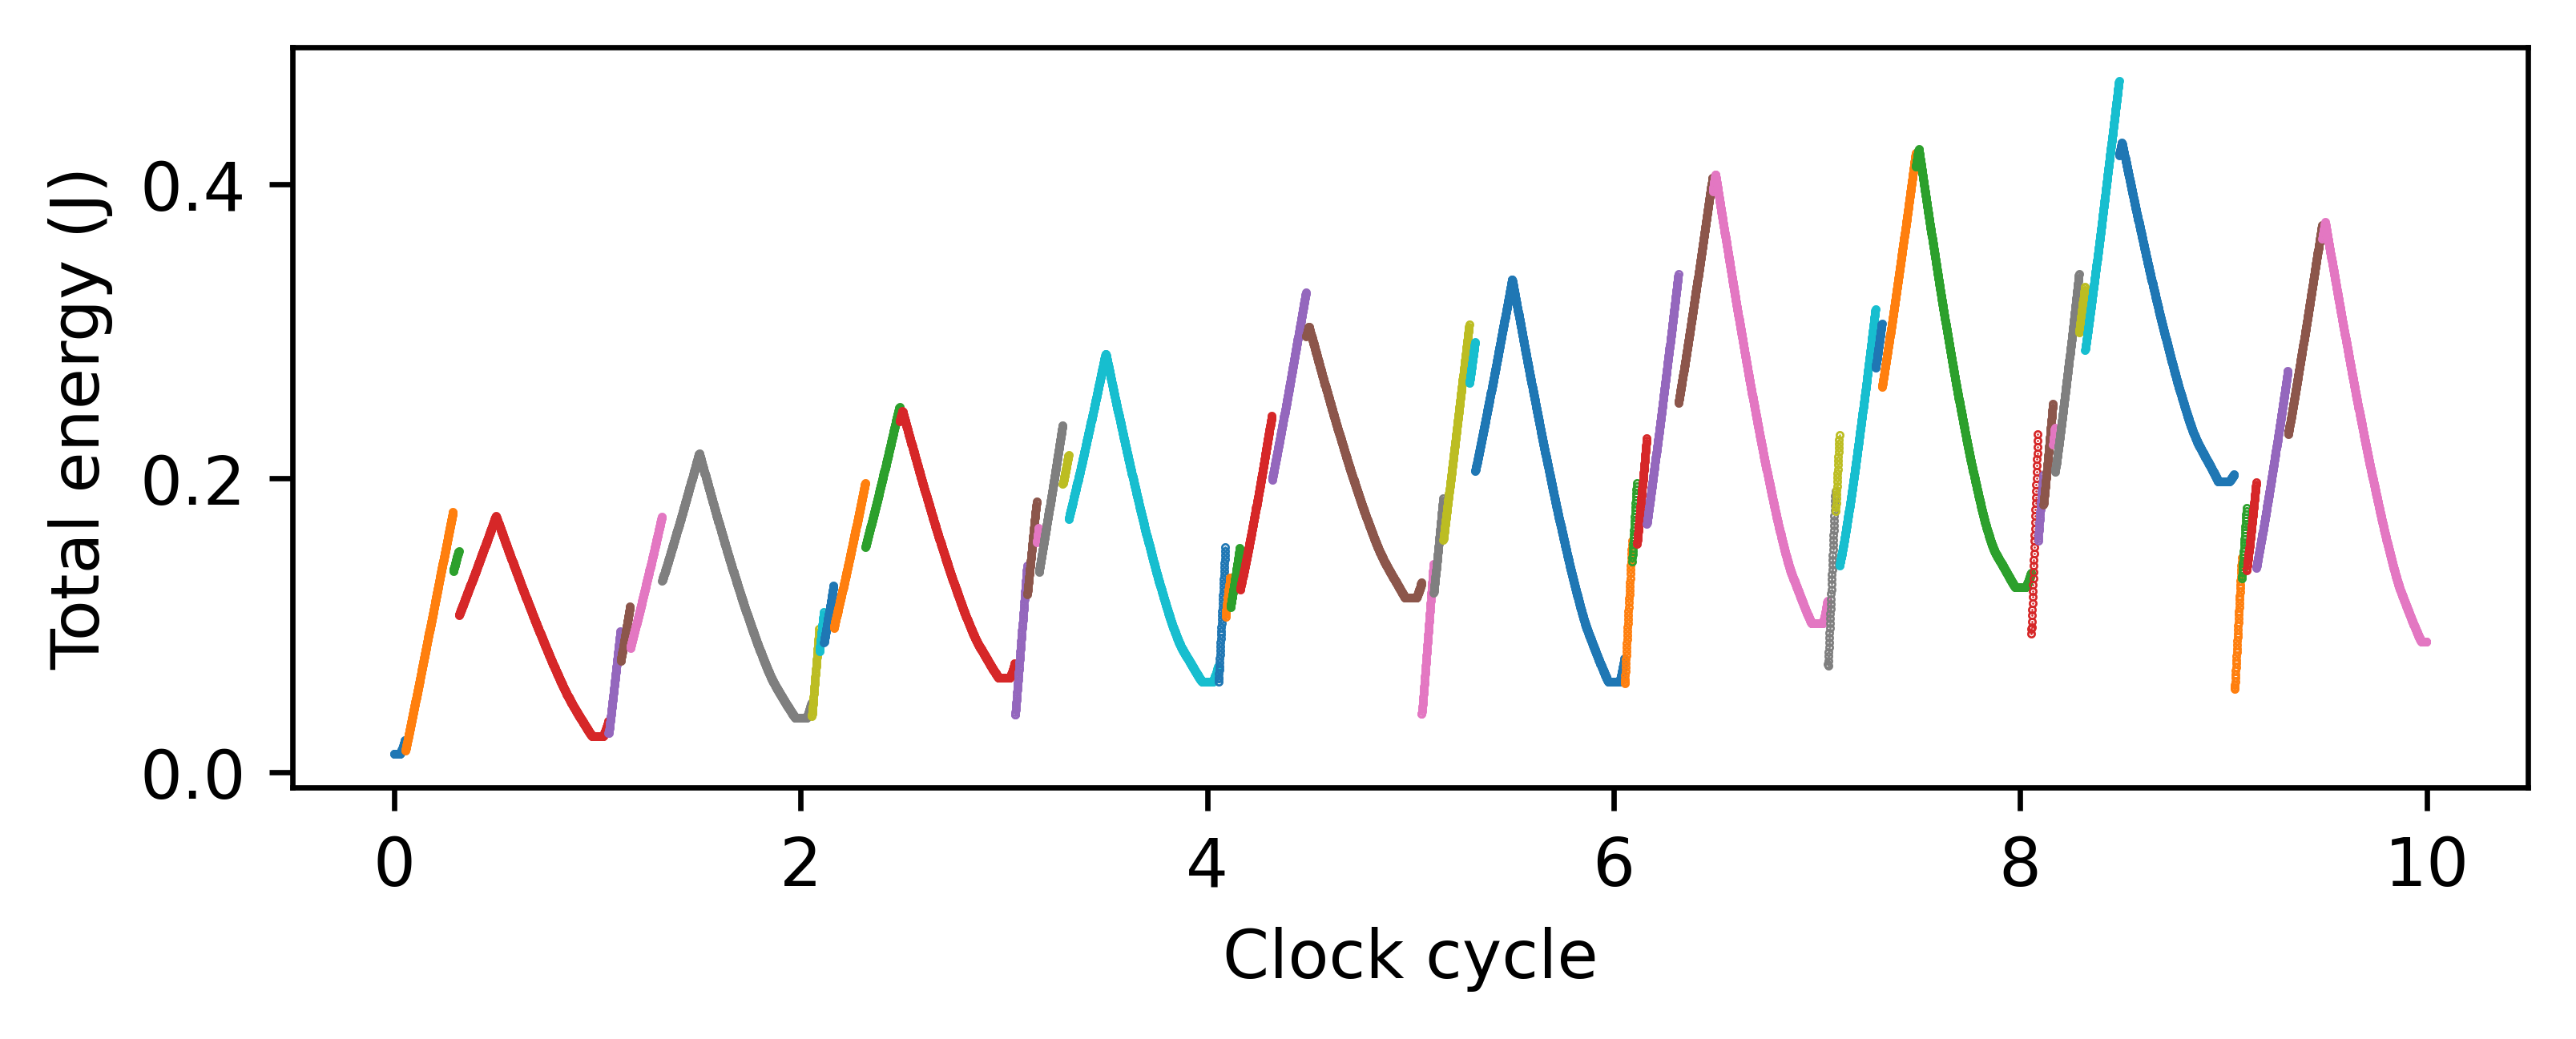

In [189]:
%matplotlib inline
#plot segmented energy and displacement 
fig = plt.figure(figsize=(6,2),dpi=600)
ax = plt.axes()
for i in range(num_segments):
    ax.scatter(segmented_time[i],segmented_energy[i],s=0.1)
    # ax.plot(segmented_time[i],segmented_displacement[i],label='Segment {}'.format(i+1))
ax.set_xlabel('Clock cycle')
ax.set_ylabel('Total energy (J)')

In [96]:
#length of each segment
segment_lengths = [len(segment) for segment in segmented_energy]
segment_lengths

[54,
 236,
 28,
 736,
 60,
 47,
 157,
 736,
 37,
 23,
 48,
 156,
 168,
 568,
 60,
 47,
 10,
 118,
 29,
 736,
 36,
 23,
 48,
 157,
 168,
 568,
 60,
 47,
 128,
 29,
 735,
 37,
 24,
 48,
 156,
 168,
 567,
 38,
 19,
 178,
 31,
 167,
 567,
 34,
 26,
 48,
 10,
 118,
 29,
 168,
 567,
 37,
 24,
 47,
 156,
 168,
 514]

In [155]:
#smooth each energy segment by downsampling 

# Initialize lists to store smoothed data
smoothed_energy = []
smoothed_displacement = []
smoothed_time = []
downsample_factor = 1
# Smooth each segment by downsampling
for i in range(num_segments):
    smoothed_energy.append(segmented_energy[i][::downsample_factor])
    smoothed_displacement.append(segmented_displacement[i][::downsample_factor])
    smoothed_time.append(segmented_time[i][::downsample_factor])

# Number of segments created
num_segments = len(smoothed_energy)



C:\Users\eoinl\AppData\Local\Temp\ipykernel_14048\3966991815.py:8: RuntimeWarning: invalid value encountered in divide
  ax2.scatter(smoothed_displacement[i][:-1],np.diff(smoothed_energy[i])/np.diff(smoothed_displacement[i]),s=0.1)


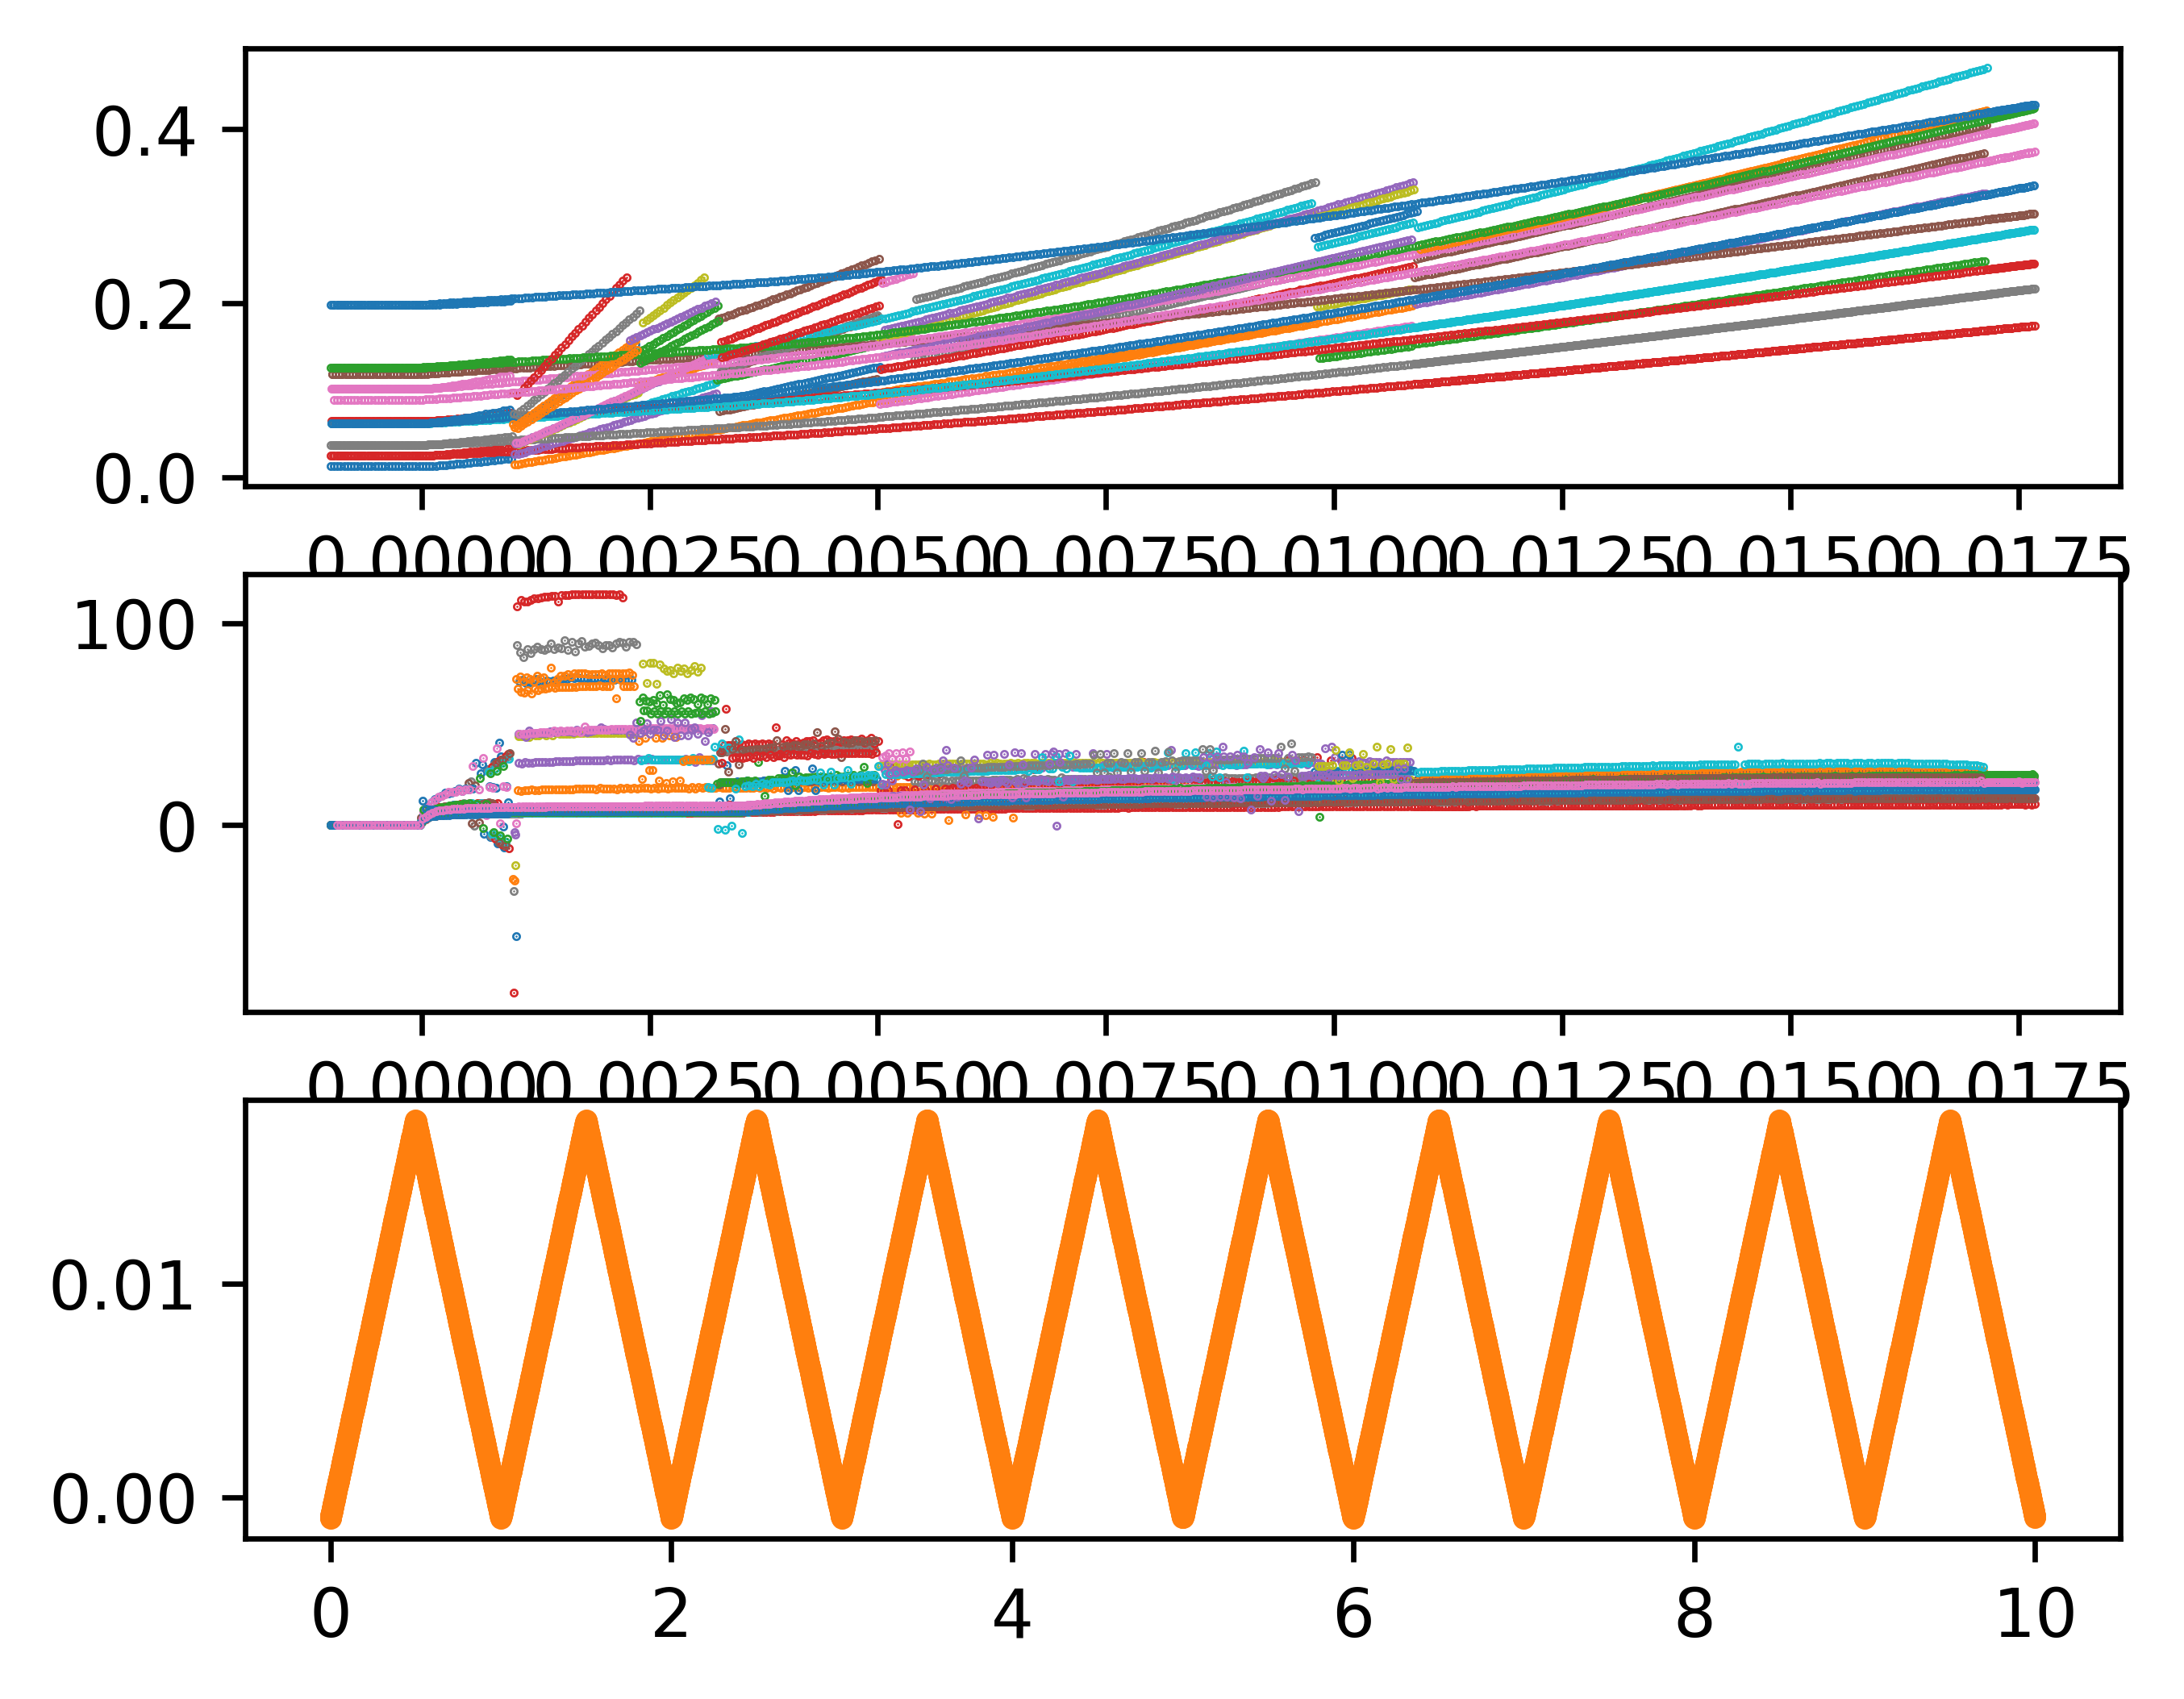

In [176]:
#plot each segment e vs u
fig = plt.figure(figsize=(5,4),dpi=600)
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
for i in range(num_segments):
    ax.scatter(smoothed_displacement[i],smoothed_energy[i],s=0.1,label='Segment {}'.format(i+1))
    ax2.scatter(smoothed_displacement[i][:-1],np.diff(smoothed_energy[i])/np.diff(smoothed_displacement[i]),s=0.1)
    ax3.scatter(smoothed_time[i],smoothed_displacement[i],s=5,color='tab:orange',label='Segment {}'.format(i+1))



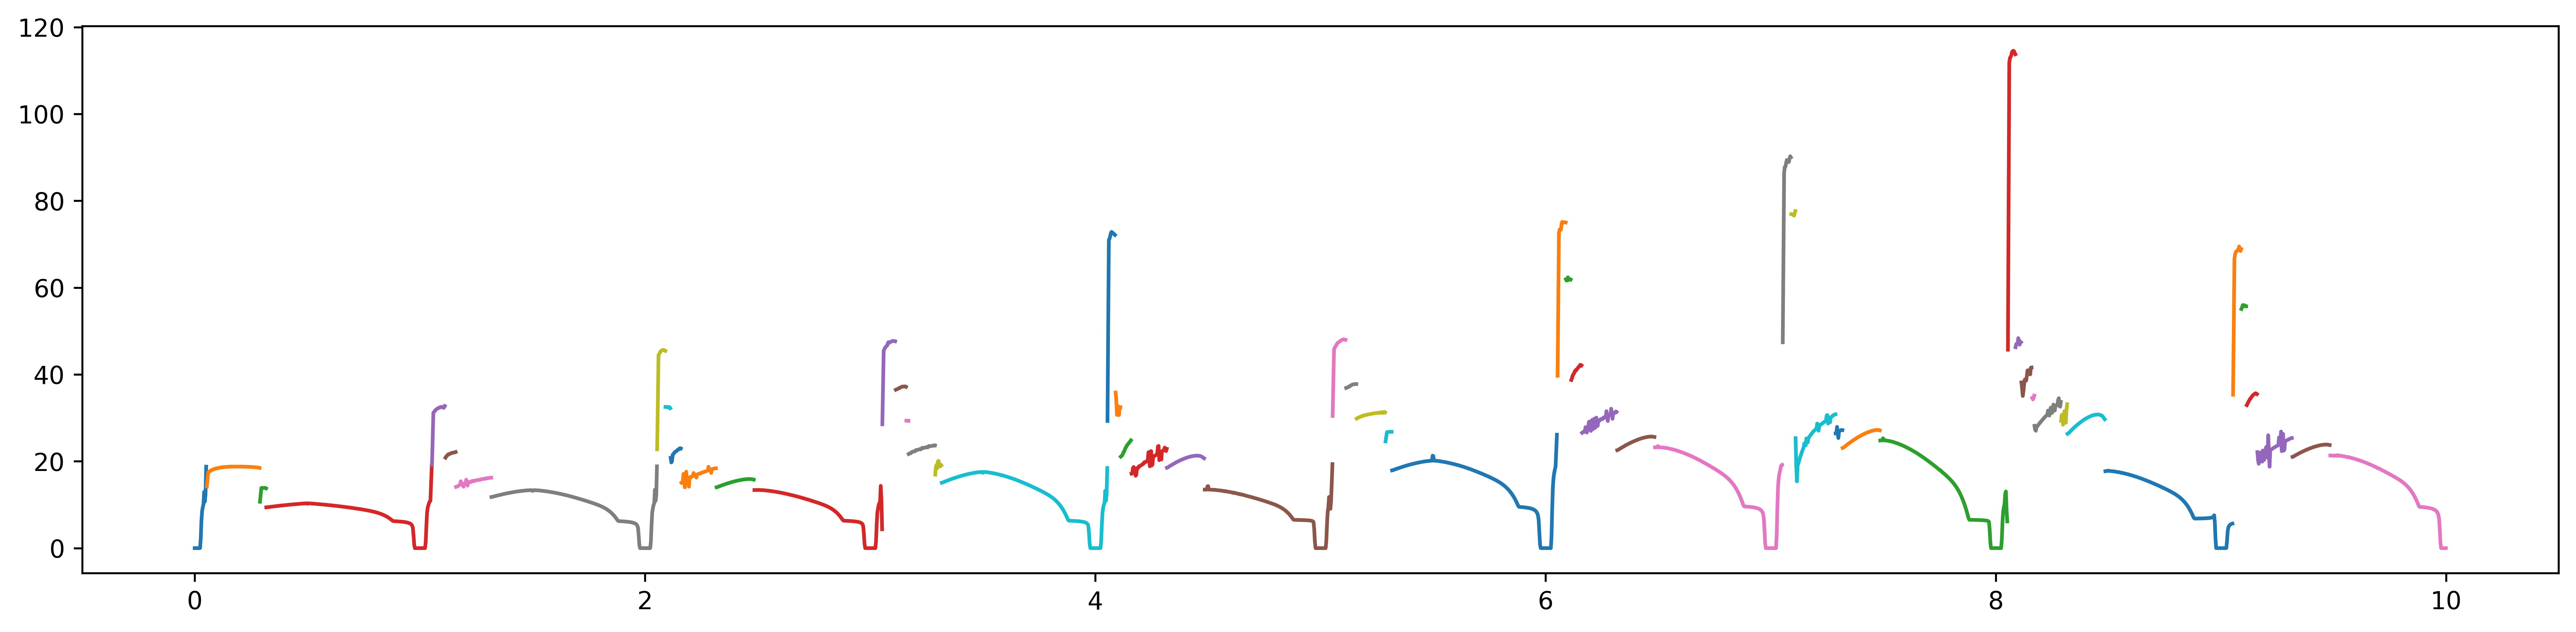

In [139]:
#plot the derivative of energy with respect to displacement over time
fig = plt.figure(figsize=(18,4),dpi=600)
ax = plt.axes()
for i in range(num_segments):
    ax.plot(smoothed_time[i],np.gradient(smoothed_energy[i],smoothed_displacement[i]),label='Segment {}'.format(i+1))